### Library Import

In [116]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['text.color'] = 'white'#'#aaaaaa'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [117]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

SyntaxError: invalid syntax (charts.py, line 54)

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [ ]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [ ]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
# print(np.array(train_images).shape)
# print(np.array(train_labels).shape)

# ###############################
# #Manual data augmentation flow#
# ###############################

# #FLIPPING
# augmented_train_images = []
# augmented_train_labels = []
# for i in range(len(train_images)):
#     augmented_train_images.append(tf.image.flip_left_right(train_images[i]))
#     augmented_train_labels.append(train_labels[i])
#     # flipped = tf.image.flip_left_right(image, 0.4)
#     # visualize(image, flipped)

# train_images = tuple(list(train_images) + augmented_train_images)
# train_labels = train_labels + tuple(augmented_train_labels)

# #SATURATION
# # saturated_train_images = []
# # saturated_train_labels = []
# # for i in range(len(train_images)):
# #     saturated_train_images.append(tf.image.adjust_saturation(train_images[i], 2))
# #     saturated_train_labels.append(train_labels[i])


# # train_images = tuple(list(train_images) + saturated_train_images)
# # train_labels = train_labels + tuple(saturated_train_labels)

# # #BRIGHTNESS
# # bright_train_images = []
# # bright_train_labels = []
# # for i in range(len(train_images)):
# #     bright_train_images.append(tf.image.adjust_brightness(train_images[i], 0.4))
# #     bright_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + bright_train_images)
# # train_labels = train_labels + tuple(bright_train_labels)

# # #CONTRAST
# # contrast_train_images = []
# # contrast_train_labels = []
# # for i in range(len(train_images)):
# #     contrast_train_images.append(tf.image.adjust_contrast(train_images[i], 0.4))
# #     contrast_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + contrast_train_images)
# # train_labels = train_labels + tuple(contrast_train_labels)



#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

# print(train_images.shape)
# print(train_labels.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)


(100, 195, 3)
(1030, 100, 195, 3)
(1030, 1)


In [ ]:
hold_out_images, hold_out_labels = zip(*test_data)

images_final_test = []
for img in hold_out_images:
    img = Image.fromarray(img)
    img = img.resize((input_shape[1], input_shape[0])) #change to shape of train images
    images_final_test.append(np.array(img))

hold_out_images = images_final_test

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0


augmented_hold_out_images = []
augmented_hold_out_labels = []
for i in range(len(hold_out_images)):
    augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
    augmented_hold_out_labels.append(hold_out_labels[i])

hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
hold_out_images.shape[1:]

# plot_images(hold_out_images, hold_out_labels)

TensorShape([100, 195, 3])

In [ ]:
#view the split of the data
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0.0,554
1,1.0,476


In [ ]:
#view the split of the data
df = pd.DataFrame([label[0] for label in hold_out_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['hold_out_label', 'count_of_label']
df

,hold_out_label,count_of_label
0,0,1918
1,1,20


# Hyperparameter Tuning

In [118]:
%reload_ext tensorboard
#! rm -rf ./logs/

# Pulling models from folder

In [119]:
modelLst = []
modelNames = []
modelDict = {}
for model in os.listdir("artifacts/modelFolder"):
    f = os.path.join("artifacts/modelFolder", model)
    modelNames.append(model)
    modelLst.append(tf.keras.models.load_model(f))

modelDict = dict(zip(modelLst,modelNames))

# for excel in os.listdir("artifacts/excelFolder"):
#     f = os.path.join("artifacts/excelFolder", excel)
#     modelDfs.append(pd.read_excel(f))  

In [120]:
# modelFromTheArchives = tf.keras.models.load_model(os.path.join("artifacts","model_20201209_107.h5"))

# restoring modelDf

In [121]:
modelDfs = []

losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
histories = []
best_thresholds = []
units = []
dropouts = []
optimizers = []
epoch = []
# for model in best_mods: #toggle to change lists
# for model in modelLst:
for model, name in modelDict.items():

    train_predictions_baseline = model.predict(train_images)

    fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
    from numpy import argmax
    J = tp- fp
    ix = argmax(J)
    best_thresh = _[ix]
    best_thresh = 1-best_thresh
    print('best thresh')
    print('-----------')
    print(best_thresh)
    print('-----------')
    best_thresholds.append(best_thresh)

    loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc= model.evaluate(test_images, test_labels)
    
    losses.append(loss)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    aucs.append(auc)
    histories.append(model.history)

    splitStr = name.split("_")
    units.append(splitStr[2])
    dropouts.append(splitStr[3])
    epoch.append(splitStr[4])
    optimizers.append(splitStr[5].replace(".h5",""))

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, histories, epoch, best_thresholds)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'histories','epochs', 'best thresholds'])#'aucs',

modelDfs.append(modelDf)
    

best thresh
-----------
0.8723841905593872
-----------
5/5 [==============================] - 109s 264ms/step - loss: 0.0995 - tp: 60.0000 - fp: 0.0000e+00 - tn: 65.0000 - fn: 4.0000 - accuracy: 0.9690 - precision: 1.0000 - recall: 0.9375 - auc: 0.9957 - prc: 0.9966
best thresh
-----------
0.3421905040740967
-----------
5/5 [==============================] - 104s 226ms/step - loss: 0.0873 - tp: 63.0000 - fp: 0.0000e+00 - tn: 65.0000 - fn: 1.0000 - accuracy: 0.9922 - precision: 1.0000 - recall: 0.9844 - auc: 0.9964 - prc: 0.9970
best thresh
-----------
0.10204559564590454
-----------


KeyboardInterrupt: 

# Running new models

In [9]:
modelLst = []
modelDfs = []

In [94]:
session_num = 0
epochLst = [2,3,4,5,6,7,8,9]
epochLst = [7]
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64]))#16, 16,32,
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.8,0.9))
dropout_rate = 0.7
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop',,'Nadam','Nadam'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
predictions = []
epoch = []
modelz = []

for epochs in epochLst:
  for num_units in HP_NUM_UNITS.domain.values:
    # for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        model.save(f"artifacts/modelFolder/model_20211212_{num_units}_{dropout_rate}_{epochs}_{optimizer}.h5")
        modelz.append(model)
        epoch.append(epochs)
        session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.7, 'optimizer': 'adam'}
Epoch 1/7
33/33 [==============================] - 104s 611ms/step - loss: 0.6252 - tp: 285.0000 - fp: 144.0000 - tn: 410.0000 - fn: 191.0000 - accuracy: 0.6748 - precision: 0.6643 - recall: 0.5987 - auc: 0.7230 - prc: 0.6955
Epoch 2/7
33/33 [==============================] - 20s 616ms/step - loss: 0.2804 - tp: 408.0000 - fp: 43.0000 - tn: 511.0000 - fn: 68.0000 - accuracy: 0.8922 - precision: 0.9047 - recall: 0.8571 - auc: 0.9552 - prc: 0.9586
Epoch 3/7
33/33 [==============================] - 21s 626ms/step - loss: 0.1500 - tp: 452.0000 - fp: 17.0000 - tn: 537.0000 - fn: 24.0000 - accuracy: 0.9602 - precision: 0.9638 - recall: 0.9496 - auc: 0.9835 - prc: 0.9876
Epoch 4/7
33/33 [==============================] - 20s 612ms/step - loss: 0.0922 - tp: 461.0000 - fp: 8.0000 - tn: 546.0000 - fn: 15.0000 - accuracy: 0.9777 - precision: 0.9829 - recall: 0.9685 - auc: 0.9918 - prc: 0.9935
Epoch 5/7
33/33 [========

In [97]:
modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, cms, histories,epoch)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'cms','histories','epochs'])#'aucs',
        
#pd.ExcelWriter

# modelDfs.append(modelDf)
modelDfs = pd.concat([modelDfs,modelDf])
# modelLst.append(modelz) #if new models were generated
modelLst.extend(modelz) #if models were saved

In [99]:
#might have to concat depending on combo of new and saved

print(len(modelLst))
# modelDfs #= pd.concat([modelDfs[0],modelDfs[1]])
modelDfs = modelDfs.reset_index()
modelDfs = modelDfs.drop(columns='index')
modelDfs

408


,accuracies,aucs,best thresholds,cms,dropouts,epochs,histories,losses,optimizers,precisions,recalls,units
0,0.968992,0.995673,0.872384,NaN,0.2,2,<keras.callbacks.History object at 0x000002669...,0.099451,adam,1.000000,0.937500,16
1,0.992248,0.996394,0.342191,NaN,0.2,2,<keras.callbacks.History object at 0x000002669...,0.087301,Nadam,1.000000,0.984375,16
2,0.883721,0.990024,0.102046,NaN,0.2,2,<keras.callbacks.History object at 0x000002669...,0.238066,RMSprop,0.818182,0.984375,16
3,0.953488,0.995553,0.956653,NaN,0.2,3,<keras.callbacks.History object at 0x000002669...,0.155498,adam,1.000000,0.906250,16
4,0.984496,0.999760,0.772194,NaN,0.2,3,<keras.callbacks.History object at 0x00000266A...,0.052762,Nadam,1.000000,0.968750,16
...,...,...,...,...,...,...,...,...,...,...,...,...
403,0.968992,0.997716,NaN,"[[65, 0], [4, 60]]",0.8,9,<keras.callbacks.History object at 0x0000026C1...,0.052204,adam,1.000000,0.937500,64
404,0.976744,0.000000,NaN,"[[65, 0], [3, 61]]",0.9,9,<keras.callbacks.History object at 0x0000026C1...,0.055626,Nadam,1.000000,0.953125,64
405,0.968992,0.999519,NaN,"[[64, 1], [3, 61]]",0.9,9,<keras.callbacks.History object at 0x0000026C1...,0.069609,RMSprop,0.983871,0.953125,64
406,0.968992,0.000000,NaN,"[[65, 0], [4, 60]]",0.9,9,<keras.callbacks.History object at 0x0000026C2...,0.096060,adam,1.000000,0.937500,64


# Iterate through one model or small set of models

In [113]:
focusModel = [modelFromTheArchives] # [modelLst[407]]
modelDfs[(modelDfs['optimizers']=='adam')&(modelDfs['dropouts']==0.7)]

,accuracies,aucs,best thresholds,cms,dropouts,epochs,histories,losses,optimizers,precisions,recalls,units
407,1.0,1.0,NaN,"[[65, 0], [0, 64]]",0.7,7,<keras.callbacks.History object at 0x0000026C8...,0.01287,adam,1.0,1.0,64


In [ ]:
counter = 0
TNrates = []
FPrates = []
FNrates = []
TPrates = []
Units = []
Dropouts = []
Optimizers = []
Epochs = []
positions = []
BestThresh = []
# for model in best_mods: #toggle to change lists
for model in focusModel:
    for thresHold in [0.4, 0.5, 0.6, 0.72, 0.85]:

        modelDetails = pd.DataFrame(modelDfs.iloc[407]).T #need to adjust positioning based on model input
        display(modelDetails)
        if pd.isnull(modelDetails['best thresholds'].values[0]):
            
            train_predictions_baseline = model.predict(train_images)

            fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
            from numpy import argmax
            J = tp- fp
            ix = argmax(J)
            best_thresh = _[ix]
            best_thresh = 1-best_thresh
            print('best thresh')
            print('-----------')
            print(best_thresh)
            print('-----------')
            BestThresh.append(best_thresh)
        
        else:
            thresh = modelDetails['best thresholds'].values[0]
            BestThresh.append(thresh)

        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresHold:
                scores.append(1)
            else:
                scores.append(0)
        
        print(thresHold)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        TNrate, FPrate, FNrate, TPrate = plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True)
    counter+=1

,accuracies,aucs,best thresholds,cms,dropouts,epochs,histories,losses,optimizers,precisions,recalls,units
407,1,1,NaN,"[[65, 0], [0, 64]]",0.7,7,<keras.callbacks.History object at 0x0000026C8...,0.0128705,adam,1,1,64


best thresh
-----------
0.9130772650241852
-----------
31/61 [==============>...............] - ETA: 5s

KeyboardInterrupt: 

# Iterate through all models and various thresholds

,accuracies,aucs,best thresholds,cms,dropouts,epochs,histories,losses,optimizers,precisions,recalls,units
0,0.968992,0.995673,0.872384,NaN,0.2,2,<keras.callbacks.History object at 0x000002669...,0.0994508,adam,1,0.9375,16


61/61 [==============================] - 32s 172ms/step
0.4
[([1], 0.9998521), ([1], 0.99465585), ([1], 0.9983607), ([1], 0.98086524), ([1], 0.99896324), ([1], 0.99949443), ([1], 0.99975616), ([1], 0.785874), ([1], 0.50888914), ([1], 0.99924254)]
[([1], 0.99949366), ([1], 0.9847121), ([1], 0.99901336), ([1], 0.9983959), ([1], 0.9963689), ([1], 0.99968034), ([1], 0.9997907), ([1], 0.7472709), ([1], 0.5755539), ([1], 0.99976504)]


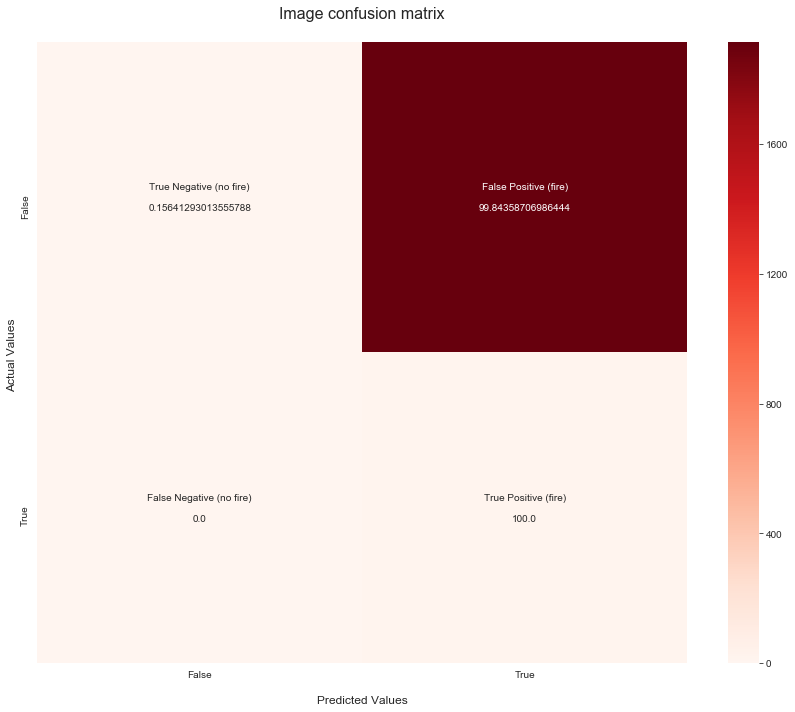

,accuracies,aucs,best thresholds,cms,dropouts,epochs,histories,losses,optimizers,precisions,recalls,units
0,0.968992,0.995673,0.872384,NaN,0.2,2,<keras.callbacks.History object at 0x000002669...,0.0994508,adam,1,0.9375,16


KeyboardInterrupt: 

In [115]:
# #if you want to do predictions on model uncomment
counter = 0
TNrates = []
FPrates = []
FNrates = []
TPrates = []
Units = []
Dropouts = []
Optimizers = []
Epochs = []
positions = []
BestThresh = []
# for model in best_mods: #toggle to change lists
for model in modelLst:
    for thresHold in [0.4, 0.5, 0.6]:
        # position = good[counter]

        # display(pd.DataFrame(modelDf.iloc[position]).T) #toggle
        modelDetails = pd.DataFrame(modelDfs.iloc[counter]).T
        display(modelDetails)
        if pd.isnull(modelDetails['best thresholds'].values[0]):
            
            train_predictions_baseline = model.predict(train_images)

            fp, tp, _ = sklearn.metrics.roc_curve(train_labels,train_predictions_baseline)
            from numpy import argmax
            J = tp- fp
            ix = argmax(J)
            best_thresh = _[ix]
            best_thresh = 1-best_thresh
            print('best thresh')
            print('-----------')
            print(best_thresh)
            print('-----------')
            BestThresh.append(best_thresh)
        
        else:
            thresh = modelDetails['best thresholds'].values[0]
            BestThresh.append(thresh)

        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresHold:
                scores.append(1)
            else:
                scores.append(0)
        
        print(thresHold)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        TNrate, FPrate, FNrate, TPrate = plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True)
        TNrates.append(TNrate)
        FPrates.append(FPrate)
        FNrates.append(FNrate)
        TPrates.append(TPrate)
        Units.append(modelDetails['units'].values[0])
        Dropouts.append(modelDetails['dropouts'].values[0])
        Optimizers.append(modelDetails['optimizers'].values[0])
        Epochs.append(modelDetails['epochs'].values[0])

    counter+=1


# Iterating through good models in different batches

In [ ]:
################################################################
#iterating through subset of good models from different batches#
################################################################

# good = [7,8,10,16,19] #modelDfs[0]
# good = [10,14,16,19,22] #modelDfs[1]
# best_mods = []
# counter = 0
# for model in modelLst[2]:
#     if counter in good:
#         best_mods.append(model)
#     else:
#         pass
#     counter+=1

good = [136, 107, 69, 46, 37, 33, 22, 20, 19, 4]
thresholds = [.32, .45, .47, .56, .75, .37, .63, .42, .35, .71]
counter = 0
truthvalues = []
positions = []
best_thresholds = []
# for model in best_mods: #toggle to change lists
for model in modelz:

    if counter in good:

        position = good[counter]
        print(position)
        thresh = thresholds[position]
        print(thresh)

        # display(pd.DataFrame(modelDf.iloc[position]).T) #toggle
        display(pd.DataFrame(modelDf.iloc[position]).T)


        predictions = model.predict(hold_out_images, verbose = 1)

        scores = []
        for prediction in predictions:
            if prediction >= thresh:
                scores.append(1)
            else:
                scores.append(0)
            
        # predictions = [prediction[0] for prediction in predictions]
        predictions1 = [prediction[0] for prediction in predictions][:10]
        predictions2 = [prediction[0] for prediction in predictions][969:979]
        
        # print(list(zip(hold_out_labels,predictions)))
        print(list(zip(hold_out_labels[:10],predictions1)))
        print(list(zip(hold_out_labels[969:979],predictions2)))

        truthvalues.append(plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=True))
        positions.append(counter)

        counter+=1
    else:
        continue

print(list(zip(truthvalues,positions)))

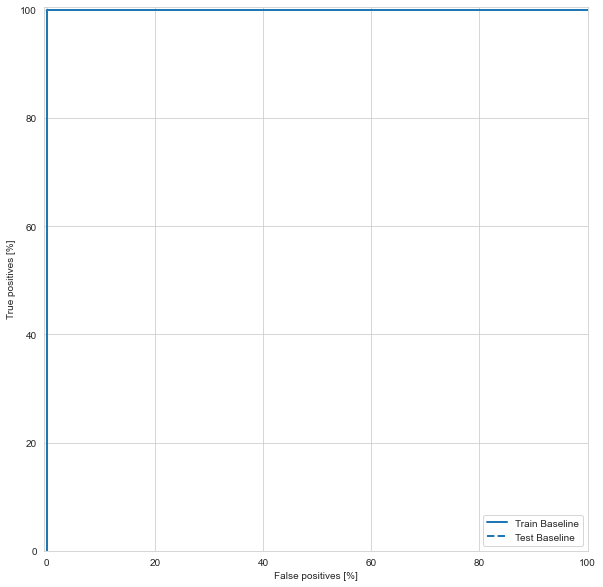

In [167]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [117]:
model.save("artifacts/model_20201207.h5")

In [146]:
line_chart(histories[0])

,epoch,variable,value
0,0,accuracy,0.658252
1,0,precision,0.612727
2,0,recall,0.707983
3,0,auc,0.748223
4,0,loss,0.590575


alt.Chart(...)